In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

from gym_power_trading.envs import PowerTradingEnv
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy

c:\Users\chen5\miniforge3\envs\rl_env2\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\chen5\AppData\Local\Temp\ipykernel_35044\2978688325.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
DEBUG:tensorflow:Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating conver

In [3]:
file_name = r"data\AEP_PSGC1_AMP_dart_Oct20.h5"
df = pd.read_hdf(file_name)
df.head()

RT_LMP  DA_LMP
MARKET_DAY NODE          TYPE    VALUE HourEnding                
2020-10-01 AEP.PSGC1.AMP Gennode LMP   1            10.02   14.33
                                       2            12.51   13.09
                                       3            12.79   12.96
                                       4            12.53   13.62
                                       5            13.43   14.49

## 24-hours worth of Observations (Current Price, Day Ahead Price, Price Difference, Battery State of Charge, Battery Avg Energy Price)

In [15]:
window = 1
# Offset by 10 b/c DA prices look 10 ticks into future
env = PowerTradingEnv(df=df, window_size=window, frame_bound=(window, len(df) - 10)) 
obs = env.reset()
for _ in tqdm(range(len(df)-10)):
    action = env.action_space.sample()
    obs, reward, done, truncated, info = env.step(action)
    if truncated:
        obs = env.reset()

100%|██████████| 30662/30662 [00:00<00:00, 58889.89it/s]


In [16]:
obs

array([13.43     ,  1.0907764,  0.       ,  0.       ], dtype=float32)

In [17]:
window = 1
venv = make_vec_env(lambda: PowerTradingEnv(df=df, window_size=window, frame_bound=(window, len(df) - 10 - 3000)), n_envs=16) # Leave last 3,000 ticks for Test

### PPO Agent (1,000,000 Iterations) w/o Normalizing Observations

Rewards: 

    - Profit From Discharge (Current Price - Avg Price) * Charge Sold
    - Charginge at price below its avg charge price

Penalty:

    - Overcharging (-1)

In [36]:
%%time
PPO_power_model_5MM = PPO('MlpPolicy', venv, device='cpu')
PPO_power_model_5MM.learn(total_timesteps=500, progress_bar=True)#5000000

CPU times: total: 0 ns
Wall time: 13.8 ms


[]

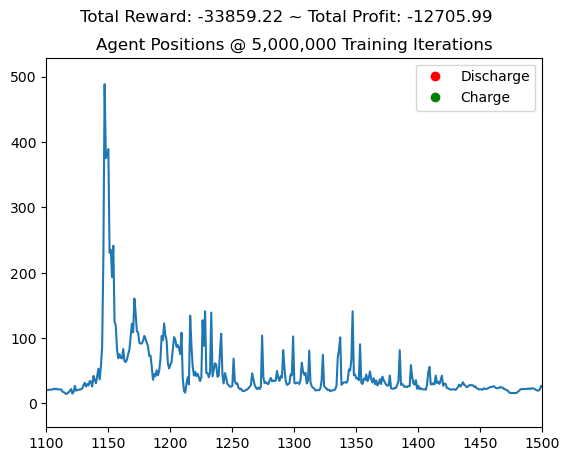

In [39]:
last_index = len(df) - 10
start_index = last_index - 3000
env2 = PowerTradingEnv(df=df, window_size=window, frame_bound=(start_index, last_index))
obs = env2.reset()
obs = obs[0]

for i in range(last_index - start_index):
    action, states = PPO_power_model_5MM.predict(obs)
    obs, rewards, term, trunc, info = env2.step(action)
    if term or trunc:
        history = env2.history
        pos = env2.render_all(title="Agent Positions @ 5,000,000 Training Iterations", xlim=(1100, 1500))
        env2.reset()

plt.plot()

In [48]:
mean_reward, reward_std = evaluate_policy(PPO_power_model_5MM, env2, n_eval_episodes=1) #100
print(f"Mean Reward:{ mean_reward:,.2f}\nReward std: {reward_std:,.2f}")

Mean Reward:-100,071.44
Reward std: 0.00


In [ ]:
mean_rewards = list()
mean_rewards.append(mean_reward)

In [ ]:
PPO_power_model_5MM.learn(total_timesteps=500, progress_bar=True)#5000000

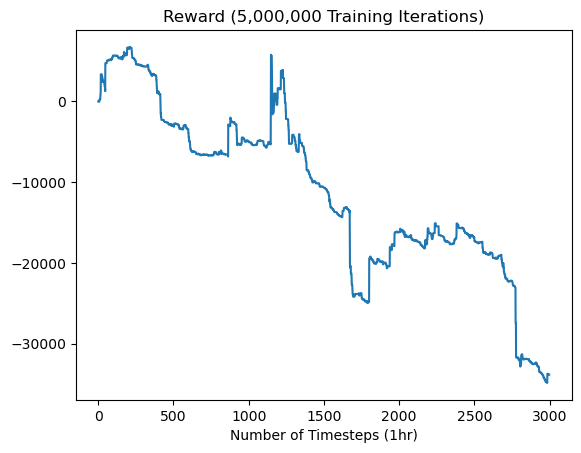

In [41]:
plt.plot(history['total_reward'])
plt.title("Reward (5,000,000 Training Iterations)")
plt.xlabel("Number of Timesteps (1hr)")
plt.show()

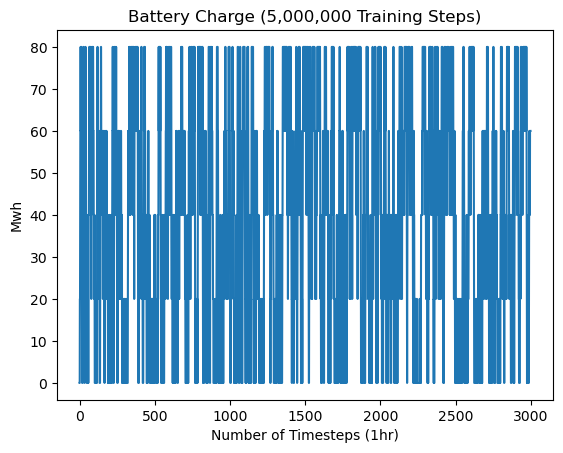

In [42]:
### PPO 10,000 Steps on Sinusoid
plt.plot(history['battery_charge'])
plt.title("Battery Charge (5,000,000 Training Steps)")
plt.ylabel("Mwh")
plt.xlabel("Number of Timesteps (1hr)")
plt.show()

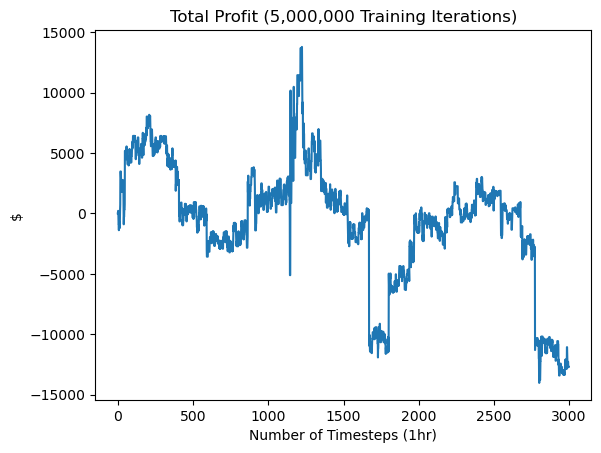

In [43]:
plt.plot(history['total_profit'])
plt.title("Total Profit (5,000,000 Training Iterations)")
plt.ylabel("$")
plt.xlabel("Number of Timesteps (1hr)")
plt.show()

In [50]:
PPO_power_model_5MM.save('PPO_power_trading_5MM_unnormalized_features')

## Normalize Observations 

(Battery Capacity 0-> 1, Battery Price Normalied by Window MA, )

In [24]:
%%time
PPO_power_model_5MM_norm = PPO('MlpPolicy', venv, device='cpu')
PPO_power_model_5MM_norm.learn(total_timesteps=5000, progress_bar=True) # 5000000

Output()

CPU times: total: 1.97 s
Wall time: 18.2 s


DEBUG:Comm:handle_msg[35fb0c8a4fc243c289fe7c3875c4984f]({'header': {'date': datetime.datetime(2024, 4, 26, 2, 40, 28, 592000, tzinfo=tzutc()), 'msg_id': '6f40ab17-b911-4a6b-b06e-d5e330c6d1ff', 'msg_type': 'comm_msg', 'session': '29f39734-62eb-4321-b292-c370a44550f3', 'username': '7a6c3826-34c1-452e-91ec-5d7269fad336', 'version': '5.2'}, 'msg_id': '6f40ab17-b911-4a6b-b06e-d5e330c6d1ff', 'msg_type': 'comm_msg', 'parent_header': {}, 'metadata': {}, 'content': {'comm_id': '35fb0c8a4fc243c289fe7c3875c4984f', 'data': {'method': 'update', 'state': {'outputs': [{'output_type': 'display_data', 'data': {'text/plain': '\x1b 100%\x1b \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b31,600/5,000 \x1b [ \x1b0:00:00\x1b < \x1b0:00:00\x1b , \x1b20,096 it/s\x1b ]\n', 'text/html': '<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,\'DejaVu Sans Mono\',consolas,\'Courier New\',monospace"><span style="color: #800080; text-decoration-color: #800080"> 10

[]

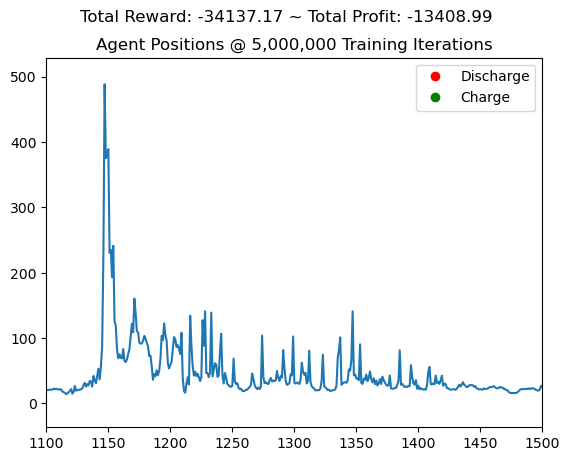

In [25]:
last_index = len(df) - 10
start_index = last_index - 3000
env2 = PowerTradingEnv(df=df, window_size=window, frame_bound=(start_index, last_index))
obs = env2.reset()
obs = obs[0]

for i in range(last_index - start_index):
    action, states = PPO_power_model_5MM_norm.predict(obs)
    obs, rewards, term, trunc, info = env2.step(action)
    if term or trunc:
        history = env2.history
        pos = env2.render_all(title="Agent Positions @ 5,000,000 Training Iterations", xlim=(1100, 1500))
        env2.reset()

plt.plot()

In [26]:
env2.history

{'total_reward': [], 'total_profit': [], 'position': [], 'battery_charge': []}

In [11]:
mean_reward, reward_std = evaluate_policy(PPO_power_model_5MM_norm, env2, n_eval_episodes=100)
print(f"Mean Reward:{ mean_reward:,.2f}\nReward std: {reward_std:,.2f}")

c:\Users\Andrew Deur\anaconda3\envs\rl_project\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean Reward:121,472.21
Reward std: 0.00


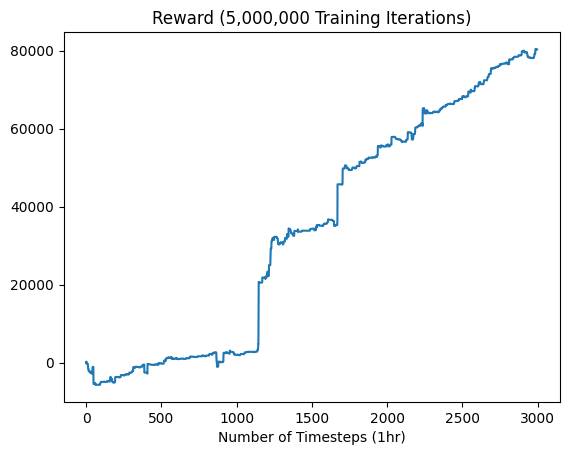

In [12]:
plt.plot(history['total_reward'])
plt.title("Reward (5,000,000 Training Iterations)")
plt.xlabel("Number of Timesteps (1hr)")
plt.show()

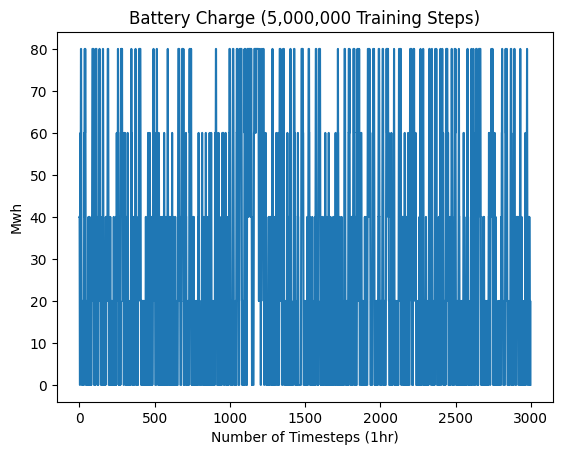

In [13]:
### PPO 10,000 Steps on Sinusoid
plt.plot(history['battery_charge'])
plt.title("Battery Charge (5,000,000 Training Steps)")
plt.ylabel("Mwh")
plt.xlabel("Number of Timesteps (1hr)")
plt.show()

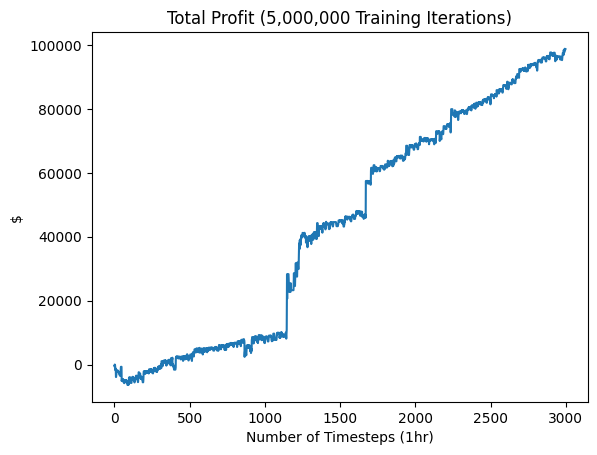

In [14]:
plt.plot(history['total_profit'])
plt.title("Total Profit (5,000,000 Training Iterations)")
plt.ylabel("$")
plt.xlabel("Number of Timesteps (1hr)")
plt.show()

In [15]:
PPO_power_model_5MM_norm.save('PPO_power_trading_5MM_normalized_features')